In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import random
import matplotlib.pyplot as plt
import math
from cka import compute_cka_between_minima

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = torch.device('cpu')
print(device)


cuda


Train size: 132, Holdout size: 132, Test size: 136


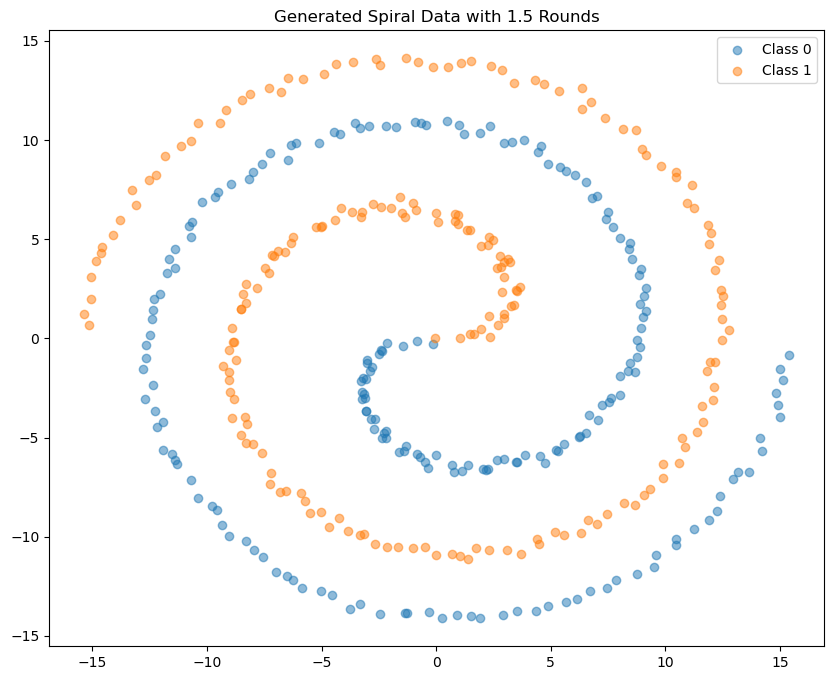

In [3]:

def generate_spiral_data(n_points = 1000, n_cycles = 5, noise_std_dev = 0.1):
    red_noise = np.random.normal(0, noise_std_dev, [2, n_points])
    blue_noise = np.random.normal(0, noise_std_dev, [2, n_points])

    # Generate Data
    theta_max = n_cycles * (2 * math.pi)
    step_size = theta_max / n_points

    red_data = [[5 * math.sqrt(t * step_size) * math.cos(t * step_size) + red_noise[0][t],
                 5 * math.sqrt(t * step_size) * math.sin(t * step_size) + red_noise[1][t]]
                for t in range(n_points)]

    blue_data = [[-5 * math.sqrt(t * step_size) * math.cos(t * step_size) + blue_noise[0][t],
                  -5 * math.sqrt(t * step_size) * math.sin(t * step_size) + blue_noise[1][t]]
                 for t in range(n_points)]

    data = np.array(red_data + blue_data)
    labels = np.array([1] * n_points + [0] * n_points)

    return list(zip(data, labels))

# Generate data
n_points = 200
n_cycles = 1.5
noise = 0.2
spiral_data = generate_spiral_data(n_points = n_points, n_cycles=n_cycles, noise_std_dev=noise)
random.shuffle(spiral_data)

# Split the data
train_ratio = 0.33
holdout_ratio = 0.33
test_ratio = 1- train_ratio - holdout_ratio

train_size = int(2*n_points * train_ratio)
holdout_size = int(2*n_points * holdout_ratio)
test_size = 2*n_points - train_size - holdout_size

print(f"Train size: {train_size}, Holdout size: {holdout_size}, Test size: {test_size}")

train_data = spiral_data[:train_size]
holdout_data = spiral_data[train_size:train_size + holdout_size]
swapped_holdout_data = [(data, 1 - label) for data, label in holdout_data]
test_data = spiral_data[train_size + holdout_size:train_size + holdout_size + test_size]

# Plot the generated spiral data
data, labels = zip(*spiral_data)
data = np.array(data)
labels = np.array(labels)

plt.figure(figsize=(10, 8))
plt.scatter(data[labels == 0][:, 0], data[labels == 0][:, 1], label='Class 0', alpha=0.5)
plt.scatter(data[labels == 1][:, 0], data[labels == 1][:, 1], label='Class 1', alpha=0.5)
plt.title(f'Generated Spiral Data with {n_cycles} Rounds')
plt.legend()
plt.show()


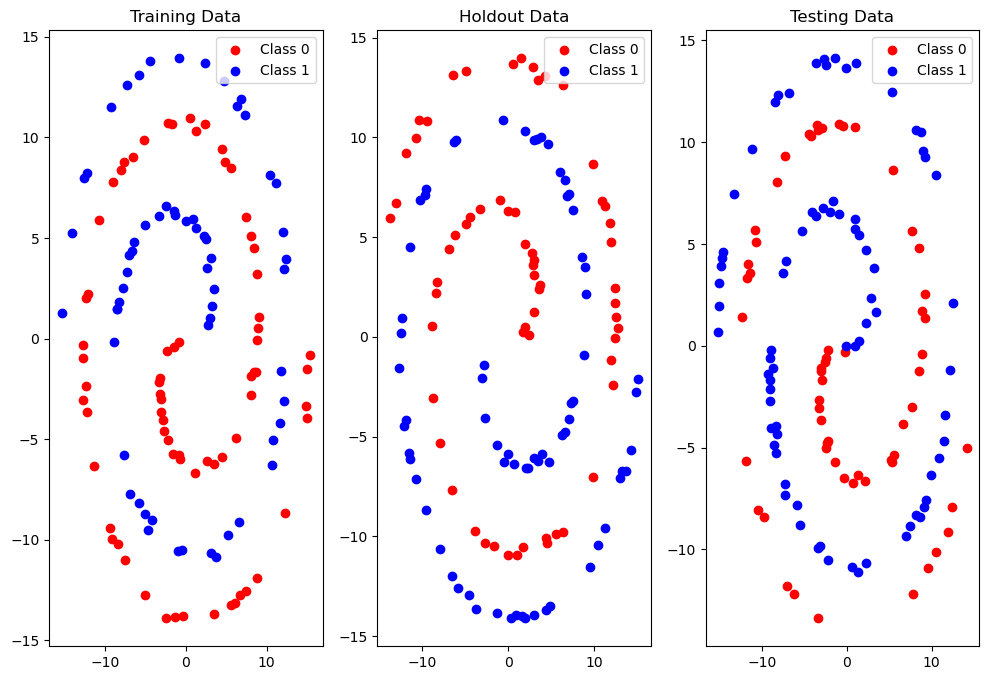

In [4]:

# Separate coordinates and labels for plotting
train_coords, train_labels = zip(*train_data)
holdout_coords, holdout_labels = zip(*swapped_holdout_data)
test_coords, test_labels = zip(*test_data)

train_coords = np.array(train_coords)
train_labels = np.array(train_labels)
holdout_coords = np.array(holdout_coords)
holdout_labels = np.array(holdout_labels)
test_coords = np.array(test_coords)
test_labels = np.array(test_labels)

# Plot the data
plt.figure(figsize=(12, 8))

plt.subplot(1, 3, 1)
plt.scatter(train_coords[train_labels == 0][:, 0], train_coords[train_labels == 0][:, 1], color='red', label='Class 0')
plt.scatter(train_coords[train_labels == 1][:, 0], train_coords[train_labels == 1][:, 1], color='blue', label='Class 1')
plt.title('Training Data')
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(holdout_coords[holdout_labels == 0][:, 0], holdout_coords[holdout_labels == 0][:, 1], color='red', label='Class 0')
plt.scatter(holdout_coords[holdout_labels == 1][:, 0], holdout_coords[holdout_labels == 1][:, 1], color='blue', label='Class 1')
plt.title('Holdout Data')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(test_coords[test_labels == 0][:, 0], test_coords[test_labels == 0][:, 1], color='red', label='Class 0')
plt.scatter(test_coords[test_labels == 1][:, 0], test_coords[test_labels == 1][:, 1], color='blue', label='Class 1')
plt.title('Testing Data')
plt.legend()

plt.show()


In [ ]:

class SpiralDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        coords, label = self.data[idx]
        return torch.tensor(coords).float(), torch.tensor(label).float().view(1)

untraining_data = train_data + swapped_holdout_data
random.shuffle(untraining_data)
untraining_coords, untraining_labels = zip(*untraining_data)
untraining_coords = np.array(untraining_coords)
untraining_labels = np.array(untraining_labels)
# Move data to device
train_data = [(torch.tensor(coords).float().to(device), torch.tensor(label).float().view(-1, 1).to(device)) for coords, label in train_data]
holdout_data = [(torch.tensor(coords).float().to(device), torch.tensor(label).float().view(-1, 1).to(device)) for coords, label in swapped_holdout_data]
test_data = [(torch.tensor(coords).float().to(device), torch.tensor(label).float().view(-1, 1).to(device)) for coords, label in test_data]
untraining_data = [(torch.tensor(coords).float().to(device), torch.tensor(label).float().view(-1, 1).to(device)) for coords, label in untraining_data]

train_dataset = SpiralDataset(train_data)
holdout_dataset = SpiralDataset(swapped_holdout_data)
test_dataset = SpiralDataset(test_data)
untraining_dataset = SpiralDataset(untraining_data)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
holdout_loader = DataLoader(holdout_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
untraining_loader = DataLoader(untraining_dataset, batch_size=64, shuffle=True)


In [6]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 25)
        self.fc2 = nn.Linear(25, 25)
        self.fc3 = nn.Linear(25, 25)
        self.fc4 = nn.Linear(25, 25)
        self.fc5 = nn.Linear(25, 25)
        self.fc6 = nn.Linear(25, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x

In [7]:
# Starting from two random initializations of the same model
model1 = Net().to(device)
model2 = Net().to(device)

# Train the models
criterion = nn.BCEWithLogitsLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

n_epochs = 1000

for epoch in range(n_epochs):
    model1.train()
    model2.train()
    for inputs, labels in train_loader:
        optimizer1.zero_grad()
        optimizer2.zero_grad()

        outputs1 = model1(inputs)
        outputs2 = model2(inputs)

        loss1 = criterion(outputs1, labels)
        loss2 = criterion(outputs2, labels)

        loss1.backward()
        loss2.backward()

        optimizer1.step()
        optimizer2.step()

model1.eval()
model2.eval()

test_loss1 = 0
test_loss2 = 0

correct1 = 0
correct2 = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs1 = model1(inputs)
        outputs2 = model2(inputs)

        labels.view(-1, 1)

        test_loss1 += criterion(outputs1, labels).item()
        test_loss2 += criterion(outputs2, labels).item()

        pred1 = (outputs1 > 0).float()
        pred2 = (outputs2 > 0).float()

        correct1 += (pred1 == labels.byte()).float().sum().item()
        correct2 += (pred2 == labels.byte()).float().sum().item()

test_loss1 /= len(test_loader.dataset)
test_loss2 /= len(test_loader.dataset)

accuracy1 = correct1 / len(test_loader.dataset)
accuracy2 = correct2 / len(test_loader.dataset)

print(f"Model 1 Test Loss: {test_loss1}, Model 1 Test Accuracy: {accuracy1}")
print(f"Model 2 Test Loss: {test_loss2}, Model 2 Test Accuracy: {accuracy2}")

/tmp/ipykernel_160764/717981965.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(coords).float(), torch.tensor(label).float().view(1)


Model 1 Test Loss: 0.008062153691699839, Model 1 Test Accuracy: 0.9264705882352942
Model 2 Test Loss: 0.012709395480616129, Model 2 Test Accuracy: 0.9117647058823529


In [8]:
train_coords = torch.tensor(train_coords).float().to(device)
train_labels = torch.tensor(train_labels).float().view(-1,1).to(device)
holdout_coords = torch.tensor(holdout_coords).float().to(device)
holdout_labels = torch.tensor(holdout_labels).float().view(-1,1).to(device)
test_coords = torch.tensor(test_coords).float().to(device)
test_labels = torch.tensor(test_labels).float().view(-1,1).to(device)

In [9]:
cka_score = compute_cka_between_minima(model1, model2, train_coords, device)
print(f"CKA score between minima: {cka_score}")

CKA score between minima: 0.8576635122299194
